In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from pymatgen.core import Composition, Element
import pickle as pkl
from matminer.featurizers.base import MultipleFeaturizer
from matminer.featurizers import composition as cf
from matminer.featurizers.conversions import StrToComposition
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.utils import shuffle
import sys, os
sys.path.append('/home/jupyter/CJK/TempTime')
from data_extraction_rxn_classification_all_targets import *
import shap
import json
from xgboost import XGBRegressor
from hyperopt import fmin, tpe, hp, STATUS_OK
import time
from scipy.stats import gaussian_kde
import matplotlib.cm as cm

In [2]:
all_elements = [Element.from_Z(i).symbol for i in range(1, 119)]

In [3]:
with open('/home/jupyter/CJK/TempTime/data/solid-state_dataset_20200713.json') as f:
    ss_data= json.load(f)
ss_reactions = ss_data["reactions"]
ss_extracted, ss_precursor_nomenclature = extract_solidstate(ss_reactions, max_pre=5)

Returning extracted data of 51574/31782 reactions.


In [4]:
with open('/home/jupyter/CJK/TempTime/data/ss_extracted_NO_IMPUTATION_precs_all_targets.pkl', 'rb') as f:
    papers = pkl.load(f)

In [5]:
# only use papers with sinter temps
papers = [x for x in papers if not np.isnan(x['temp_time_vector'][1])]

In [10]:
targets = [x['target'] for x in papers]
precursors = [x['precursors'] for x in papers]
temps = [x['temp_time_vector'][0] for x in papers]
dois = [x['DOI'] for x in papers]

In [11]:
# get means
only_ss_rxns = []
for target, precs, temps, doi in zip(targets, precursors, temps, dois):
    if len(precs) == 0:
        continue
    found = False
    for result in only_ss_rxns:
        if result["target"] == target and set(result["precursors"]) == set(precs):
            result["ss_sinter_temps"].append(temps)
            result["DOIs"].append(doi)
            found = True
    if not found:
        new_result = {}
        new_result["target"] = target
        new_result["precursors"] = precs
        new_result["ss_sinter_temps"] = [temps]
        new_result["DOIs"] = [doi]
        only_ss_rxns.append(new_result)

In [12]:
num_pts = [len(x["ss_sinter_temps"]) for x in only_ss_rxns]

In [13]:
pd.Series(num_pts).value_counts()

1     10253
2      1388
3       305
4       132
5        50
6        42
7        26
8        25
9        14
11       11
12        7
10        7
13        5
14        4
16        3
15        3
18        3
17        2
19        2
20        2
50        1
42        1
26        1
31        1
35        1
65        1
21        1
22        1
46        1
24        1
70        1
63        1
dtype: int64

In [9]:
# change precursor functional groups back
for rxn in only_ss_rxns:
    for i in range(len(rxn['precursors'])):
        rxn['precursors'][i] = ss_precursor_nomenclature[Composition(rxn['precursors'][i])]

In [10]:
# Onehot precursor functional groups
m_anions = ['H2PO4', 'HPO4', 'HCO3', 'HSO4', 'HSO3', 'C2O4']
d_anions = ['CO3', 'PO4', 'PO3', 'OH', 'NH4', 'NO3', 'NO2', 'SO4', 'SO3', 'CN'] #BO3, VO4, NH2
s_anions = ['F', 'B', 'P', 'Cl', 'F', 'Br', 'S', 'N', 'O', 'C']
ions = m_anions + d_anions + s_anions + ['Org'] + ['Ac'] + ['Elem'] + ['Other']

In [11]:
ss_anion_dict = {x: [] for x in ions}
for rxn in only_ss_rxns:
    anion_dict = {x: [] for x in ions}
    for prec in rxn['precursors']:
        found = False
        # check acetate first
        if 'CH3COO' in prec:
            anion_dict['Ac'].append(prec)
            found = True
        # check organic
        elif all(Element(x) in Composition(prec).elements for x in ['C', 'H', 'O']) and Element('N') not in Composition(prec).elements:
            anion_dict['Org'].append(prec)
            found = True
        else:
            for anion in ions:
                # special check for elemental anions
                if (anion in all_elements and Element(anion) in Composition(prec).elements) or (anion not in all_elements and anion in prec):
                    anion_dict[anion].append(prec)
                    found = True
                    break
        if not found:
            # check if precursor is elemental
            if prec in all_elements:
                anion_dict['Elem'].append(prec)
            else:
                anion_dict['Other'].append(prec)
    # create fractional embedding
    
    for key in anion_dict:
        ss_anion_dict[key].append(len(anion_dict[key]) / len(rxn['precursors']))
        

# add in melting point features

In [12]:
with open('/home/jupyter/CJK/TempTime/rxn_classification_fraction/data/full_mp.json', 'r') as f:
    full_mp = json.load(f)

In [13]:
full_mp = {Composition(x): full_mp[x] for x in full_mp}
full_mp_median = np.median(list(full_mp.values()))

In [14]:
# add MP features
for new_result in only_ss_rxns:
    # precursor MP features
    melting_points = [full_mp.get(Composition(x), full_mp_median) for x in new_result["precursors"]]
    new_result['feature_exp_min_mp'] = min(melting_points)
    new_result['feature_exp_max_mp'] = max(melting_points)
    new_result['feature_exp_mean_mp'] = np.mean(melting_points)
    new_result['feature_exp_div_mp'] = max(melting_points) - min(melting_points)

In [17]:
target_names = [x["target"] for x in only_ss_rxns]
precursors = [x["precursors"] for x in only_ss_rxns]
temps = [np.mean(x["ss_sinter_temps"]) for x in only_ss_rxns]
num_pts = [len(x["ss_sinter_temps"]) for x in only_ss_rxns]
feature_exp_min_mp = [x['feature_exp_min_mp'] for x in only_ss_rxns]
feature_exp_max_mp = [x['feature_exp_max_mp'] for x in only_ss_rxns]
feature_exp_mean_mp = [x['feature_exp_mean_mp'] for x in only_ss_rxns]
feature_exp_div_mp = [x['feature_exp_div_mp'] for x in only_ss_rxns]

In [18]:
feature_calculators = MultipleFeaturizer([
    cf.ElementFraction()
])

In [19]:
feature_labels = feature_calculators.feature_labels()

In [20]:
data = pd.DataFrame()
data["targets"] = target_names
data["precursors"] = precursors
data["temperatures"] = temps
df = StrToComposition(target_col_id="composition_obj").featurize_dataframe(data, "targets", ignore_errors=True)
df = feature_calculators.featurize_dataframe(df, col_id="composition_obj", ignore_errors = True)

In [21]:
for key in ss_anion_dict:
    df[key + "_prec"] = ss_anion_dict[key]

In [22]:
df['feature_exp_min_mp'] = feature_exp_min_mp
df['feature_exp_max_mp'] = feature_exp_max_mp
df['feature_exp_mean_mp'] = feature_exp_mean_mp
df['feature_exp_div_mp'] = feature_exp_div_mp

In [24]:
df

,targets,precursors,temperatures,composition_obj,H,He,Li,Be,B,C,...,O_prec,C_prec,Org_prec,Ac_prec,Elem_prec,Other_prec,feature_exp_min_mp,feature_exp_max_mp,feature_exp_mean_mp,feature_exp_div_mp
0,Sr0.5Nd0.5CoO3,"[Co3O4, Nd2O3, SrCO3]",1200.0,"(Sr, Nd, Co, O)",0.0,0,0.000000,0.0,0.0,0.0,...,0.666667,0.0,0.0,0.0,0.0,0.0,947.0,2272.0,1572.000000,1325.0
1,NdCoO3,"[Co3O4, Nd2O3]",1200.0,"(Nd, Co, O)",0.0,0,0.000000,0.0,0.0,0.0,...,1.000000,0.0,0.0,0.0,0.0,0.0,947.0,2272.0,1609.500000,1325.0
2,Sr0.4Pr0.6CoO3,"[Co2O3, Pr6O11, SrCO3]",1050.0,"(Sr, Pr, Co, O)",0.0,0,0.000000,0.0,0.0,0.0,...,0.666667,0.0,0.0,0.0,0.0,0.0,150.0,2183.0,1276.666667,2033.0
3,Sr0.4Gd0.6CoO3,"[Co2O3, Gd2O3, SrCO3]",1050.0,"(Sr, Gd, Co, O)",0.0,0,0.000000,0.0,0.0,0.0,...,0.666667,0.0,0.0,0.0,0.0,0.0,150.0,2310.0,1319.000000,2160.0
4,Li1.3Mn0.65Ni0.35O2.3,"[LiOH, MnO2, Ni(NO3)2]",800.0,"(Li, Mn, Ni, O)",0.0,0,0.282609,0.0,0.0,0.0,...,0.333333,0.0,0.0,0.0,0.0,0.0,56.7,680.0,423.900000,623.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12343,Sm0.05Ce0.95O2,"[CeO2, Sm2O3]",1690.0,"(Sm, Ce, O)",0.0,0,0.000000,0.0,0.0,0.0,...,1.000000,0.0,0.0,0.0,0.0,0.0,2335.0,2400.0,2367.500000,65.0
12344,Sm0.55Ce0.45O2,"[CeO2, Sm2O3]",1690.0,"(Sm, Ce, O)",0.0,0,0.000000,0.0,0.0,0.0,...,1.000000,0.0,0.0,0.0,0.0,0.0,2335.0,2400.0,2367.500000,65.0
12345,ZrTa2ZnO8,"[Ta2O5, ZnO, ZrO2]",1360.0,"(Zr, Ta, Zn, O)",0.0,0,0.000000,0.0,0.0,0.0,...,1.000000,0.0,0.0,0.0,0.0,0.0,1800.0,2710.0,2161.666667,910.0
12346,La2Y0.32Zr1.68O6.84,"[La2O3, Y2O3, ZrO2]",1650.0,"(La, Y, Zr, O)",0.0,0,0.000000,0.0,0.0,0.0,...,1.000000,0.0,0.0,0.0,0.0,0.0,2315.0,2710.0,2488.000000,395.0


In [25]:
zero_cols = [ col for col, is_zero in ((df == 0).sum() == df.shape[0]).items() if is_zero ]

In [26]:
zero_cols

['He',
 'Ne',
 'Ar',
 'Kr',
 'Tc',
 'I',
 'Xe',
 'Pm',
 'Po',
 'At',
 'Rn',
 'Fr',
 'Ra',
 'Ac',
 'Pa',
 'Np',
 'Cm',
 'Bk',
 'Cf',
 'Es',
 'Fm',
 'Md',
 'No',
 'Lr',
 'HCO3_prec',
 'HSO4_prec',
 'HSO3_prec',
 'PO3_prec',
 'NO2_prec',
 'CN_prec']

In [146]:
omit_columns = ['targets', 'precursors', 'temperatures', 'composition_obj'] + zero_cols
X_columns = [x for x in df.columns if x not in omit_columns]
y_column = 'temperatures'
X_df = df[X_columns]
X_columns = list(X_df.columns)
X = X_df.values
y = df[y_column].values
print("Shape of X: {}".format(X.shape))
print("Shape of y: {}".format(y.shape))
X, y, n_pts = shuffle(X, y, num_pts, random_state=42)
n_pts = np.array(n_pts)

Shape of X: (12348, 106)
Shape of y: (12348,)


# Hyperparameter tuning and model metrics

In [147]:
# hyperparameter tuning
# XGB hyperparameters

n_estimators = [25, 50, 100, 200]
max_depth=[3, 6, 9]
learning_rate = [0.1, 0.2, 0.3]
colsample_bytree = [0.6, 0.8, 1]
colsample_bylevel = [0.6, 0.8, 1]
min_child_weight = [1, 2, 3]
subsample = [0.7, 0.9, 1]

orig_parameters = {'n_estimators': n_estimators,
              'max_depth': max_depth,
              'learning_rate': learning_rate,
              'colsample_bytree': colsample_bytree,
              'colsample_bylevel': colsample_bylevel,
              'min_child_weight': min_child_weight,
              'subsample': subsample
}

# Create the random grid
parameters = {'n_estimators': hp.choice('n_estimators', n_estimators),
              'max_depth': hp.choice('max_depth', max_depth),
              'learning_rate': hp.choice('learning_rate', learning_rate),
              'colsample_bytree': hp.choice('colsample_bytree', colsample_bytree),
              'colsample_bylevel': hp.choice('colsample_bylevel', colsample_bylevel),
              'min_child_weight': hp.choice('min_child_weight', min_child_weight),
              'subsample': hp.choice('subsample', subsample)
}

def objective(parameters):
    regr = XGBRegressor(
        n_estimators=parameters['n_estimators'],
        max_depth=parameters['max_depth'],
        learning_rate=parameters['learning_rate'],
        colsample_bytree=parameters['colsample_bytree'],
        colsample_bylevel=parameters['colsample_bylevel'],
        min_child_weight=parameters['min_child_weight'],
        subsample=parameters['subsample'],
        objective ="reg:squarederror"
    )

    regr.fit(X_train_curr, y_train_curr, eval_metric='rmse')
    
    y_pred_val = regr.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred_val, squared=False)
    
    return {'loss': rmse, 'status': STATUS_OK}

In [148]:
best_params = []
best_estimators = []
y_pred_train, y_pred_test = [], []
X_train_k, X_test_k = [], []
y_train_k, y_test_k = [], []
n_pts_train_k, n_pts_test_k = [], []

kf = KFold(n_splits=10, shuffle=False)
start = time.time()

for train_index, test_index in kf.split(X):
    # print((time.time() - start) / 60)
    # create train and test for this cv split
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    n_pts_train, n_pts_test = n_pts[train_index], n_pts[test_index]

    # create val split for this cv split from train
    # 72/18/10 split
    X_train_curr, X_val, y_train_curr, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)
    
    best_parameters = fmin(fn=objective, space=parameters, algo=tpe.suggest, max_evals=100)
    
    # convert index to value
    for key in best_parameters:
        best_parameters[key] = orig_parameters[key][best_parameters[key]]
        
    
    best_params.append(best_parameters)
    
    # get best estimator and get train and test predictions
    
    regr_best = XGBRegressor(
        n_estimators=best_parameters['n_estimators'],
        max_depth=best_parameters['max_depth'],
        learning_rate=best_parameters['learning_rate'],
        colsample_bytree=best_parameters['colsample_bytree'],
        colsample_bylevel=best_parameters['colsample_bylevel'],
        min_child_weight=best_parameters['min_child_weight'],
        subsample=best_parameters['subsample'],
        objective='reg:squarederror', 
    )
    
    regr_best.fit(X_train, y_train, eval_metric='rmse')
    
    best_estimators.append(regr_best)
    
    y_pred_train.append(regr_best.predict(X_train))
    y_pred_test.append(regr_best.predict(X_test))
    
    X_train_k.append(X_train)
    X_test_k.append(X_test)
    
    y_train_k.append(y_train)
    y_test_k.append(y_test)
    
    n_pts_train_k.append(n_pts_train)
    n_pts_test_k.append(n_pts_test)

100%|██████████| 100/100 [00:59<00:00,  1.68trial/s, best loss: 105.69520536940544]


In [351]:
maes, rmses, r2s, mres = [], [], [], []
for i, j in zip(y_test_k, y_pred_test):
    maes.append(mean_absolute_error(i, j))
    rmses.append(mean_squared_error(i, j, squared=False))
    mres.append(np.mean((np.abs(j-i)/i)*100))
    r2s.append(r2_score(i, j))

In [352]:
print(np.mean(maes), np.std(maes))
print(np.mean(rmses), np.std(rmses))
print(np.mean(r2s), np.std(r2s))
print(np.mean(mres), np.std(mres))

59.72925518821105 2.774570820039324
100.1100385322579 4.491578194557329
0.8454190360509426 0.011929261145734681
5.683156750983503 0.37251518777013276


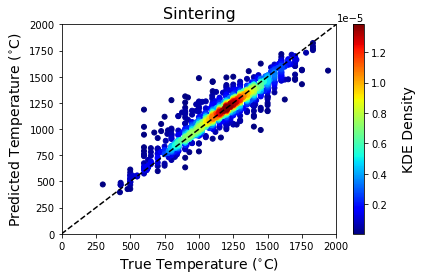

In [346]:
# make a regression figure
fig, ax = plt.subplots()
to_plot_x = y_test_k[np.argmin(rmses)]
to_plot_y = y_pred_test[np.argmin(rmses)]

# Calculate the point density
xy = np.vstack([to_plot_x,to_plot_y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
to_plot_x, to_plot_y, z = to_plot_x[idx], to_plot_y[idx], z[idx]

ax.scatter(to_plot_x, to_plot_y, c=z, cmap=cm.jet, s=25)
cbar = plt.colorbar(ax_)
cbar.set_label("KDE Density", labelpad=15, fontsize=14)

plt.xlim(0, 2000)
plt.ylim(0, 2000)
plt.plot([0, 2000], [0, 2000], color='black', linestyle='dashed')
ax.set_title("Sintering", fontsize=16)
ax.set_xlabel("True Temperature ($^{\circ}$C)", fontsize=14)
ax.set_ylabel("Predicted Temperature ($^{\circ}$C)", fontsize=14)
fig.tight_layout()
plt.show()
fig.savefig("figures/xgb_sinter_parity.png", dpi=150)

# Check error as function of num. points

In [234]:
all_maes = []
all_rmses = []
all_rmses_stdev = []
all_r2 = []
# min_num_pts = [i for i in range(1, 26)]
min_num_pts = [1, 5, 10, 15, 20, 25]
lens = []
stdevs = []
for i in min_num_pts:
    curr = []
    curr_true = []
    all_fold_rmse = []
    for fold in range(len(n_pts_test_k)):
        curr_fold = []
        curr_fold_true = []
        for ind in range(len(n_pts_test_k[fold])):
            if n_pts_test_k[fold][ind] >= i:
                curr.append(y_test_k[fold][ind])
                curr_true.append(y_pred_test[fold][ind])
                
                curr_fold.append(y_test_k[fold][ind])
                curr_fold_true.append(y_pred_test[fold][ind])
        try:
            all_fold_rmse.append(mean_squared_error(curr_fold_true, curr_fold, squared=False))
        except:
            all_fold_rmse.append(0)
    all_maes.append(mean_absolute_error(curr_true, curr))
    all_rmses.append(mean_squared_error(curr_true, curr, squared=False))
    all_r2.append(r2_score(curr_true, curr))
    lens.append(len(curr))
    curr_rmses = []
    all_rmses_stdev.append(np.std(all_fold_rmse))
    

In [235]:
cum_pts = np.cumsum(lens)/np.sum(lens)

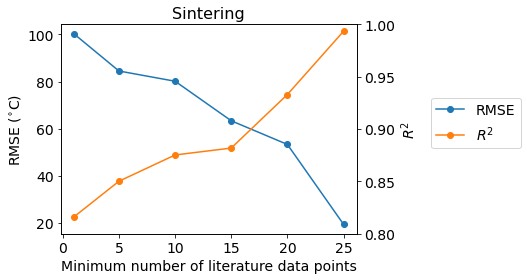

In [357]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot(min_num_pts, all_rmses, marker='o', label="RMSE")
ax2.plot(min_num_pts, all_r2, marker='o', color='tab:orange', label="$R^2$")
# ax.errorbar(min_num_pts, all_rmses, all_rmses_stdev)
ax.set_xlabel("Minimum number of literature data points", fontsize=14)
ax.set_ylabel("RMSE ($^{\circ}$C)", fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)
ax2.set_ylabel("$R^2$", fontsize=14)
lgd=fig.legend(bbox_to_anchor =(1.23, 0.67), fontsize=14)
ax.set_title("Sintering", fontsize=16)
ax2.set_ylim([0.8, 1])
fig.tight_layout()
plt.show()
fig.savefig("figures/xgb_sinter_error_plot.png", dpi=150,  bbox_extra_artists=(lgd,), bbox_inches='tight')